# library importing

In [20]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import os
import sklearn
import warnings
import random
from keras import Input
from tensorflow.keras.models import Model
from unicodedata import normalize
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
warnings.filterwarnings('ignore', module='sklearn')

# Ready for Data

## Data Test

In [2]:
# 오디오 데이터
DATA_DIR_TRAIN = '/Users/ichanhui/Desktop/TranslationAudio/train/'
DATA_DIR_TEST = '/Users/ichanhui/Desktop/TranslationAudio/test/'

In [3]:
# Example : scream 폴더의 음성 파일 접근
wav, sr = librosa.load(DATA_DIR_TRAIN + 'scream/4.wav', sr=16000)
print('sr : ', sr)
print('wav shape : ', wav.shape)
print('length : ', wav.shape[0]/float(sr), 'secs')

sr :  16000
wav shape :  (60696,)
length :  3.7935 secs


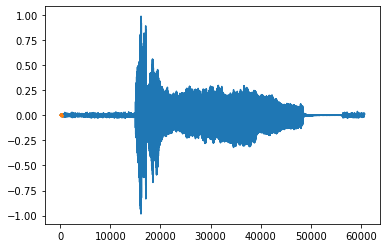

In [4]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

## Train Data Set

In [5]:
# Data set List, include (raw data, mfcc data, y data)
train_dataset = []
test_dataset = []

dataset0 = [] # 비명소리
dataset1 = [] # 일반소리

# split each set into raw data, mfcc data, and y data
train_x = []
train_mfccs = []
train_y = []

test_x = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.001

In [6]:
input_nfft = int(round(sr*frame_length))
input_stride = int(round(sr*frame_stride))
print(input_nfft, input_stride)

400 16


In [7]:
# train data scream 을 넣는다.
for filename in os.listdir(DATA_DIR_TRAIN + "scream/"):
    filename = normalize('NFC', filename) # 'ㅇㅡㅁ.wav' -> '음.wav'
    try:
        if '.wav' not in filename:
            continue
        
        wav, sr = librosa.load(DATA_DIR_TRAIN + "scream/" + filename, sr=16000)
        
        mfcc = librosa.feature.mfcc(y=wav, sr=sr)
        #mfcc = sklearn.processing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 400)
        
        # Scream Dataset 에 추가
        train_dataset.append((padded_mfcc, 0))
    except Exception as e:
        print(filename, e)
        raise

# train data non_scream 을 넣는다.
for filename in os.listdir(DATA_DIR_TRAIN + "non_scream/"):
    filename = normalize('NFC', filename)
    try:
        if '.wav' not in filename:
            continue
        
        wav, sr = librosa.load(DATA_DIR_TRAIN + "non_scream/" + filename, sr=16000)
        
        mfcc = librosa.feature.mfcc(y=wav, sr=sr)
        #mfcc = sklearn.processing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 400)
        
        # non_scream Dataset 에 추가
        train_dataset.append((padded_mfcc, 1))
    except Exception as e:
        print(filename, e)
        raise

/Users/ichanhui/opt/anaconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [8]:
# test data scream 을 넣는다.
for filename in os.listdir(DATA_DIR_TEST + "test_scream/"):
    filename = normalize('NFC', filename)
    try:
        if '.wav' not in filename:
            continue
        
        wav, sr = librosa.load(DATA_DIR_TEST + "test_scream/" + filename, sr=16000)
        
        input_nfft = int(round(sr*frame_length))
        input_stride = int(round(sr*frame_stride))
        
        mfcc = librosa.feature.mfcc(y=wav, sr=sr)
        #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 400)
        
        
        # test scream dataset 에 추가
        test_dataset.append((padded_mfcc, 0))
    except Exception as e:
        print(filename, e)
        raise

# test data non_scream 을 넣는다.
for filename in os.listdir(DATA_DIR_TEST + "test_non_scream/"):
    filename = normalize('NFC', filename)
    try:
        if '.wav' not in filename:
            continue
        
        wav, sr = librosa.load(DATA_DIR_TEST + "test_non_scream/" + filename, sr=16000)
        
        input_nfft = int(round(sr*frame_length))
        input_stride = int(round(sr*frame_stride))
        
        mfcc = librosa.feature.mfcc(y=wav, sr=sr)
        #mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 400)
        
        # test non_scream dataset 에 추가
        test_dataset.append((padded_mfcc, 1))
    except Exception as e:
        print(filename, e)
        raise


In [9]:
# 데이터 셋 셔플
random.shuffle(test_dataset)
random.shuffle(train_dataset)

train_mfccs = [a for (a,b) in train_dataset]
train_y = [b for (a,b) in train_dataset]

test_mfccs = [a for (a,b) in test_dataset]
test_y = [b for (a,b) in test_dataset]

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs : ', train_mfccs.shape)
print('train_y : ', train_y.shape)

print('test_mfccs : ', test_mfccs.shape)
print('test_y : ', test_y.shape)

train_mfccs :  (3069, 20, 400)
train_y :  (3069, 2)
test_mfccs :  (486, 20, 400)
test_y :  (486, 2)


# MFCC feature 학습

In [10]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape : ', train_X_ex.shape)
print('test X shape : ', test_X_ex.shape)

train X shape :  (3069, 20, 400, 1)
test X shape :  (486, 20, 400, 1)


In [36]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
#m = BatchNormalization()(m)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(32)(m)
#m = BatchNormalization()(m)
m = Activation("relu")(m)

op = Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 20, 400, 1)]      0         
                                                                 
 conv2d_32 (Conv2D)          (None, 17, 397, 96)       1632      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 4, 99, 96)        0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 38016)             0         
                                                                 
 dense_18 (Dense)            (None, 32)                1216544   
                                                                 
 activation_9 (Activation)   (None, 32)                0         
                                                           

In [37]:
# 만약 3개 이상의 클래스 분류를 해야한다면 categorical_crossentropy 를 사용
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
96/96 [==============================] - 5s 44ms/step - loss: 1.0570 - accuracy: 0.8530 - val_loss: 0.3108 - val_accuracy: 0.9362
Epoch 2/100
96/96 [==============================] - 4s 42ms/step - loss: 0.2254 - accuracy: 0.9303 - val_loss: 0.1367 - val_accuracy: 0.9671
Epoch 3/100
96/96 [==============================] - 4s 42ms/step - loss: 0.1595 - accuracy: 0.9391 - val_loss: 0.1330 - val_accuracy: 0.9733
Epoch 4/100
96/96 [==============================] - 4s 42ms/step - loss: 0.1478 - accuracy: 0.9475 - val_loss: 0.1760 - val_accuracy: 0.9753
Epoch 5/100
96/96 [==============================] - 4s 43ms/step - loss: 0.1223 - accuracy: 0.9498 - val_loss: 0.1118 - val_accuracy: 0.9712
Epoch 6/100
96/96 [==============================] - 4s 43ms/step - loss: 0.1286 - accuracy: 0.9479 - val_loss: 0.1121 - val_accuracy: 0.9712
Epoch 7/100
49/96 [==============>...............] - ETA: 1s - loss: 0.1117 - accuracy: 0.9509

KeyboardInterrupt: 

In [ ]:
hop_length = 160
n_fft = 400

file_path_ = "/content/drive/MyDrive/Data"

audio_data = []
for root, dirs, files in os.walk(file_path_):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            y, sr = librosa.load(file_path, sr=None)
            audio_data.append((file_path, y, sr))

print("읽은 오디오 파일 수:", len(audio_data))

for file_path, signal, sample_rate in audio_data:
    signal, sample_rate = librosa.load(file_path, sr=16000)
    MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=100)
    MFCCs = sklearn.preprocessing.scale(MFCCs, axis=1)
    pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    padded_mfcc = pad2d(MFCCs, 400)

print("MFCCs shape : ", MFCCs.shape)
print("pad shape : ", padded_mfcc.shape)
librosa.display.specshow(padded_mfcc, sr=16000, x_axis='time')